In [2]:
import os
import warnings
base_path = os.path.abspath("../")
os.chdir(base_path)
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from lime import lime_tabular
import eli5
import shap

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
plt.style.use('fivethirtyeight')

In [6]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [7]:
# Crude way of generating multi-treatment, so ATE/feature importances are NOT meant to be interpreted below
w_multi = np.array(['treatment_A', 'treatment_B', 'treatment_C', 'control'] * int(n_samples/4))
e_multi = {x: e for x in w_multi}
assert w_multi.shape[0] == n_samples

## S Learner

In [104]:
slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([ 0.00563742, -0.00303771,  0.00012907])

In [108]:
slearner.feature_importance(normalize=True, method='gini')

,treatment_A,treatment_B,treatment_C
Feature_2,0.084333,0.083333,0.076667
Feature_0,0.080667,0.073000,0.074333
Feature_1,0.074667,0.080667,0.080667
Feature_3,0.074667,0.072333,0.070667
Feature_4,0.060000,0.059000,0.064667
Feature_8,0.036667,0.035000,0.031333
Feature_21,0.036000,0.028333,0.035000
Feature_23,0.035333,0.034333,0.038667
Feature_13,0.034667,0.029333,0.026667
Feature_6,0.033333,0.034000,0.040333


In [153]:
slearner.feature_importance(normalize=False, method='gini')

,treatment_A,treatment_B,treatment_C
Feature_2,253,250,230
Feature_0,242,219,223
Feature_1,224,242,242
Feature_3,224,217,212
Feature_4,180,177,194
Feature_8,110,105,94
Feature_21,108,85,105
Feature_23,106,103,116
Feature_13,104,88,80
Feature_6,100,102,121


In [113]:
slearner.feature_importance(X=X, treatment=w_multi, y=y, method='permutation')

,treatment_A,treatment_B,treatment_C
Feature_0,0.447847,0.424912,0.458702
Feature_1,0.439287,0.446503,0.427802
Feature_3,0.305854,0.313710,0.304302
Feature_2,0.119131,0.118315,0.121878
Feature_4,0.113346,0.104466,0.115807
Feature_15,0.024615,0.014078,0.017254
Feature_23,0.023904,0.021464,0.017335
Feature_7,0.021641,0.018518,0.011984
Feature_13,0.020961,0.019863,0.015615
Feature_22,0.020801,0.013609,0.018345


In [115]:
slearner.feature_importance(X=X, treatment=w_multi, y=y, method='shapley')

,treatment_A,treatment_B,treatment_C
Feature_1,0.262559,0.267172,0.258137
Feature_0,0.260146,0.251480,0.273118
Feature_3,0.240822,0.248649,0.248559
Feature_4,0.122144,0.122519,0.126571
Feature_2,0.118476,0.121202,0.129568
Feature_23,0.016293,0.014185,0.014456
Feature_15,0.015154,0.011312,0.012539
Feature_22,0.014109,0.008569,0.011590
Feature_13,0.013096,0.012876,0.010889
Feature_7,0.012732,0.012404,0.007465


## T Learner

In [116]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([ 0.01173109, -0.00438832, -0.00334051]),
 array([-0.00625762, -0.02228536, -0.02153525]),
 array([0.02971981, 0.01350872, 0.01485423]))

In [123]:
tlearner.feature_importance(normalize=True, method='gini')

Control Learner                         Treatment Learner  \
               treatment_A treatment_B treatment_C       treatment_A   
Feature_0         0.068333    0.068333    0.068333          0.067333   
Feature_1         0.068000    0.068000    0.068000          0.066333   
Feature_2         0.066333    0.066333    0.066333          0.066333   
Feature_3         0.066333    0.066333    0.066333          0.062333   
Feature_4         0.057667    0.057667    0.057667          0.054667   
Feature_20        0.039000    0.039000    0.039000          0.031667   
Feature_12        0.037667    0.037667    0.037667          0.030333   
Feature_5         0.037667    0.037667    0.037667          0.026000   
Feature_14        0.037000    0.037000    0.037000          0.037000   
Feature_6         0.036667    0.036667    0.036667          0.039000   
Feature_19        0.035333    0.035333    0.035333          0.033000   
Feature_13        0.035333    0.035333    0.035333          0.038667   
Feature_23        0.035000    0.035000    0.035000          0.035333   
Feature_22        0.034667    0.034667    0.034667          0.042000   
Feature_15        0.034333    0.034333    0.034333          0.037000   
Feature_7         0.033667    0.033667    0.033667          0.035333   
Feature_11        0.033000    0.033000    0.033000          0.043000   
Feature_16        0.032667    0.032667    0.032667          0.030333   
Feature_8         0.032333    0.032333    0.032333          0.030000   
Feature_21        0.031000    0.031000    0.031000          0.035000   
Feature_10        0.030667    0.030667    0.030667          0.038667   
Feature_9         0.030667    0.030667    0.030667          0.026333   
Feature_18        0.030333    0.030333    0.030333          0.030333   
Feature_17        0.029333    0.029333    0.029333          0.034000   
Feature_24        0.027000    0.027000    0.027000          0.030000   

                                    
           treatment_B treatment_C  
Feature_0     0.067333    0.070000  
Feature_1     0.076333    0.072667  
Feature_2     0.062667    0.073667  
Feature_3     0.066667    0.067667  
Feature_4     0.067667    0.054667  
Feature_20    0.030667    0.025000  
Feature_12    0.029667    0.032333  
Feature_5     0.030333    0.030667  
Feature_14    0.031333    0.037667  
Feature_6     0.031000    0.043667  
Feature_19    0.036000    0.032333  
Feature_13    0.032667    0.029000  
Feature_23    0.031333    0.041333  
Feature_22    0.030667    0.033000  
Feature_15    0.038000    0.033667  
Feature_7     0.036333    0.032000  
Feature_11    0.034667    0.029000  
Feature_16    0.036333    0.032667  
Feature_8     0.032333    0.040667  
Feature_21    0.038333    0.033333  
Feature_10    0.029333    0.035000  
Feature_9     0.028333    0.029667  
Feature_18    0.027333    0.026333  
Feature_17    0.038667    0.025333  
Feature_24    0.036000    0.038667

In [124]:
tlearner.feature_importance(normalize=False, method='gini')

Control Learner                         Treatment Learner  \
               treatment_A treatment_B treatment_C       treatment_A   
Feature_0              205         205         205               202   
Feature_1              204         204         204               199   
Feature_2              199         199         199               199   
Feature_3              199         199         199               187   
Feature_4              173         173         173               164   
Feature_20             117         117         117                95   
Feature_12             113         113         113                91   
Feature_5              113         113         113                78   
Feature_14             111         111         111               111   
Feature_6              110         110         110               117   
Feature_19             106         106         106                99   
Feature_13             106         106         106               116   
Feature_23             105         105         105               106   
Feature_22             104         104         104               126   
Feature_15             103         103         103               111   
Feature_7              101         101         101               106   
Feature_11              99          99          99               129   
Feature_16              98          98          98                91   
Feature_8               97          97          97                90   
Feature_21              93          93          93               105   
Feature_10              92          92          92               116   
Feature_9               92          92          92                79   
Feature_18              91          91          91                91   
Feature_17              88          88          88               102   
Feature_24              81          81          81                90   

                                    
           treatment_B treatment_C  
Feature_0          202         210  
Feature_1          229         218  
Feature_2          188         221  
Feature_3          200         203  
Feature_4          203         164  
Feature_20          92          75  
Feature_12          89          97  
Feature_5           91          92  
Feature_14          94         113  
Feature_6           93         131  
Feature_19         108          97  
Feature_13          98          87  
Feature_23          94         124  
Feature_22          92          99  
Feature_15         114         101  
Feature_7          109          96  
Feature_11         104          87  
Feature_16         109          98  
Feature_8           97         122  
Feature_21         115         100  
Feature_10          88         105  
Feature_9           85          89  
Feature_18          82          79  
Feature_17         116          76  
Feature_24         108         116

In [125]:
tlearner.feature_importance(X=X, treatment=w_multi, y=y, method='permutation')

Control Learner                         Treatment Learner  \
               treatment_A treatment_B treatment_C       treatment_A   
Feature_0         0.410890    0.385902    0.418144          0.379885   
Feature_1         0.400399    0.390974    0.382620          0.388839   
Feature_3         0.276229    0.280271    0.273549          0.259645   
Feature_4         0.093001    0.095091    0.091814          0.081065   
Feature_2         0.090834    0.090255    0.090651          0.087883   
Feature_23        0.015947    0.015601    0.016168          0.012474   
Feature_12        0.015798    0.015818    0.012637          0.008408   
Feature_13        0.014479    0.013566    0.011852          0.014158   
Feature_14        0.012967    0.012775    0.010180          0.012111   
Feature_11        0.012408    0.010401    0.011895          0.015488   
Feature_6         0.011776    0.012560    0.012131          0.011996   
Feature_19        0.011600    0.009919    0.010829          0.009903   
Feature_8         0.011416    0.009435    0.011673          0.008929   
Feature_15        0.011402    0.010788    0.010295          0.014535   
Feature_5         0.010875    0.010933    0.010187          0.009380   
Feature_16        0.009712    0.009150    0.010196          0.010529   
Feature_22        0.009394    0.009031    0.009907          0.015084   
Feature_20        0.009318    0.009751    0.009778          0.009745   
Feature_9         0.009282    0.009617    0.007913          0.006019   
Feature_21        0.008865    0.009410    0.011334          0.011098   
Feature_10        0.007701    0.007522    0.006436          0.012110   
Feature_24        0.007453    0.009220    0.006603          0.007505   
Feature_17        0.006969    0.006639    0.007777          0.006825   
Feature_7         0.006855    0.007493    0.006763          0.016502   
Feature_18        0.006065    0.007262    0.004712          0.008937   

                                    
           treatment_B treatment_C  
Feature_0     0.359768    0.417350  
Feature_1     0.431676    0.379413  
Feature_3     0.280590    0.277078  
Feature_4     0.086227    0.089283  
Feature_2     0.077998    0.092804  
Feature_23    0.007749    0.011548  
Feature_12    0.007346    0.008238  
Feature_13    0.008472    0.008379  
Feature_14    0.007454    0.011595  
Feature_11    0.009979    0.007704  
Feature_6     0.007715    0.014090  
Feature_19    0.010545    0.010098  
Feature_8     0.010346    0.009676  
Feature_15    0.010811    0.009152  
Feature_5     0.010978    0.011954  
Feature_16    0.011327    0.012070  
Feature_22    0.006787    0.012208  
Feature_20    0.005827    0.008461  
Feature_9     0.009494    0.006904  
Feature_21    0.012192    0.011131  
Feature_10    0.008979    0.010650  
Feature_24    0.010606    0.008049  
Feature_17    0.011411    0.006705  
Feature_7     0.014568    0.010304  
Feature_18    0.007483    0.007197

In [126]:
tlearner.feature_importance(X=X, treatment=w_multi, y=y, method='shapley')

Control Learner                         Treatment Learner  \
               treatment_A treatment_B treatment_C       treatment_A   
Feature_0         0.263230    0.259867    0.265140          0.254151   
Feature_1         0.261906    0.265171    0.265501          0.259689   
Feature_3         0.237769    0.240923    0.236960          0.231607   
Feature_4         0.126314    0.126978    0.125747          0.113553   
Feature_2         0.116723    0.114998    0.116863          0.106855   
Feature_23        0.025002    0.025206    0.025176          0.015208   
Feature_13        0.021027    0.020779    0.020891          0.022362   
Feature_14        0.020489    0.020141    0.020305          0.018331   
Feature_12        0.018565    0.018654    0.018319          0.012794   
Feature_5         0.018432    0.018363    0.018321          0.014860   
Feature_22        0.017554    0.017650    0.017271          0.022968   
Feature_21        0.017534    0.017705    0.017653          0.016056   
Feature_8         0.016795    0.016323    0.016760          0.014010   
Feature_15        0.016055    0.016339    0.016611          0.018135   
Feature_6         0.016046    0.015771    0.016032          0.018857   
Feature_11        0.015734    0.015540    0.015971          0.024590   
Feature_19        0.015666    0.016030    0.015488          0.014223   
Feature_18        0.015647    0.015924    0.015715          0.012664   
Feature_20        0.014856    0.014703    0.014781          0.013386   
Feature_10        0.014488    0.014372    0.014710          0.015790   
Feature_9         0.013288    0.012968    0.013264          0.010779   
Feature_24        0.013274    0.013118    0.013040          0.014772   
Feature_16        0.011895    0.011971    0.011943          0.016765   
Feature_17        0.011439    0.011571    0.011397          0.010406   
Feature_7         0.010607    0.010381    0.010405          0.021168   

                                    
           treatment_B treatment_C  
Feature_0     0.238871    0.276346  
Feature_1     0.269500    0.254834  
Feature_3     0.249906    0.248426  
Feature_4     0.123215    0.126340  
Feature_2     0.112342    0.130540  
Feature_23    0.011494    0.013636  
Feature_13    0.011944    0.011808  
Feature_14    0.014485    0.017799  
Feature_12    0.010420    0.016504  
Feature_5     0.015901    0.014074  
Feature_22    0.009927    0.022542  
Feature_21    0.016557    0.018892  
Feature_8     0.016941    0.016763  
Feature_15    0.019349    0.015248  
Feature_6     0.013578    0.021563  
Feature_11    0.015249    0.011301  
Feature_19    0.016134    0.016135  
Feature_18    0.012050    0.015802  
Feature_20    0.012924    0.015216  
Feature_10    0.019593    0.016090  
Feature_9     0.012386    0.011695  
Feature_24    0.019556    0.014511  
Feature_16    0.017879    0.020555  
Feature_17    0.019111    0.013604  
Feature_7     0.023117    0.014794

## X Learner

In [127]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, e_multi, w_multi, y)

(array([-0.00659799, -0.01808618, -0.01587525]),
 array([-0.02241614, -0.03385353, -0.031895  ]),
 array([ 0.00922016, -0.00231884,  0.0001445 ]))

In [129]:
xlearner.feature_importance(normalize=True, method='gini')

Tau - Control Learner                          \
                     treatment_A treatment_B treatment_C   
Feature_0               0.047000    0.055000    0.046000   
Feature_4               0.046667    0.040333    0.045000   
Feature_16              0.045000    0.042333    0.034333   
Feature_2               0.044667    0.040667    0.045000   
Feature_23              0.044667    0.040000    0.045667   
Feature_13              0.043667    0.036667    0.039333   
Feature_1               0.043000    0.042333    0.039333   
Feature_6               0.043000    0.048000    0.037667   
Feature_20              0.042000    0.041000    0.044667   
Feature_12              0.041667    0.041333    0.041000   
Feature_24              0.041000    0.039000    0.037333   
Feature_15              0.040333    0.040000    0.045333   
Feature_5               0.040000    0.042667    0.034333   
Feature_3               0.040000    0.043333    0.050000   
Feature_7               0.039000    0.032333    0.033333   
Feature_14              0.038667    0.037667    0.038000   
Feature_21              0.038667    0.034667    0.038667   
Feature_19              0.038333    0.036000    0.038667   
Feature_22              0.037667    0.033667    0.040333   
Feature_11              0.036333    0.036000    0.041667   
Feature_8               0.035667    0.043000    0.042000   
Feature_17              0.034667    0.046667    0.035667   
Feature_18              0.033667    0.034000    0.031333   
Feature_10              0.032333    0.037333    0.041333   
Feature_9               0.032333    0.036000    0.034000   

           Tau - Treatment Learner                          
                       treatment_A treatment_B treatment_C  
Feature_0                 0.050000    0.052333    0.049333  
Feature_4                 0.039333    0.036333    0.037667  
Feature_16                0.034667    0.036667    0.040333  
Feature_2                 0.042667    0.042333    0.049667  
Feature_23                0.044667    0.037333    0.041333  
Feature_13                0.035000    0.039667    0.038667  
Feature_1                 0.046667    0.043333    0.051333  
Feature_6                 0.043667    0.047000    0.037667  
Feature_20                0.037333    0.037333    0.035667  
Feature_12                0.029333    0.035333    0.043333  
Feature_24                0.031000    0.032333    0.039667  
Feature_15                0.030333    0.046000    0.040000  
Feature_5                 0.040333    0.041333    0.035333  
Feature_3                 0.038000    0.043000    0.044667  
Feature_7                 0.039333    0.032667    0.035000  
Feature_14                0.038333    0.042667    0.045667  
Feature_21                0.040667    0.045333    0.036667  
Feature_19                0.040000    0.037333    0.030000  
Feature_22                0.045333    0.031667    0.036333  
Feature_11                0.045000    0.040667    0.038667  
Feature_8                 0.035333    0.038000    0.037667  
Feature_17                0.041333    0.045333    0.035333  
Feature_18                0.048333    0.041000    0.040333  
Feature_10                0.046667    0.032000    0.038667  
Feature_9                 0.036667    0.043000    0.041000

In [130]:
xlearner.feature_importance(normalize=False, method='gini')

Tau - Control Learner                          \
                     treatment_A treatment_B treatment_C   
Feature_0                    141         165         138   
Feature_4                    140         121         135   
Feature_16                   135         127         103   
Feature_2                    134         122         135   
Feature_23                   134         120         137   
Feature_13                   131         110         118   
Feature_1                    129         127         118   
Feature_6                    129         144         113   
Feature_20                   126         123         134   
Feature_12                   125         124         123   
Feature_24                   123         117         112   
Feature_15                   121         120         136   
Feature_5                    120         128         103   
Feature_3                    120         130         150   
Feature_7                    117          97         100   
Feature_14                   116         113         114   
Feature_21                   116         104         116   
Feature_19                   115         108         116   
Feature_22                   113         101         121   
Feature_11                   109         108         125   
Feature_8                    107         129         126   
Feature_17                   104         140         107   
Feature_18                   101         102          94   
Feature_10                    97         112         124   
Feature_9                     97         108         102   

           Tau - Treatment Learner                          
                       treatment_A treatment_B treatment_C  
Feature_0                      150         157         148  
Feature_4                      118         109         113  
Feature_16                     104         110         121  
Feature_2                      128         127         149  
Feature_23                     134         112         124  
Feature_13                     105         119         116  
Feature_1                      140         130         154  
Feature_6                      131         141         113  
Feature_20                     112         112         107  
Feature_12                      88         106         130  
Feature_24                      93          97         119  
Feature_15                      91         138         120  
Feature_5                      121         124         106  
Feature_3                      114         129         134  
Feature_7                      118          98         105  
Feature_14                     115         128         137  
Feature_21                     122         136         110  
Feature_19                     120         112          90  
Feature_22                     136          95         109  
Feature_11                     135         122         116  
Feature_8                      106         114         113  
Feature_17                     124         136         106  
Feature_18                     145         123         121  
Feature_10                     140          96         116  
Feature_9                      110         129         123

In [131]:
xlearner.feature_importance(X=X, treatment=w_multi, y=y, method='permutation')

Tau - Control Learner                          \
                     treatment_A treatment_B treatment_C   
Feature_17             -0.021346   -0.036649   -0.025808   
Feature_9              -0.025298   -0.023521   -0.039865   
Feature_10             -0.028882   -0.032873   -0.037380   
Feature_18             -0.030470   -0.036506   -0.049677   
Feature_24             -0.031184   -0.046245   -0.037754   
Feature_19             -0.031455   -0.033342   -0.042676   
Feature_14             -0.034242   -0.041461   -0.045892   
Feature_22             -0.034899   -0.035823   -0.032933   
Feature_7              -0.035037   -0.028725   -0.028501   
Feature_21             -0.036602   -0.037100   -0.038929   
Feature_12             -0.041031   -0.037214   -0.048408   
Feature_6              -0.041301   -0.044949   -0.036567   
Feature_15             -0.042404   -0.040326   -0.049380   
Feature_8              -0.043905   -0.044026   -0.036818   
Feature_5              -0.044190   -0.047935   -0.037527   
Feature_11             -0.044579   -0.042168   -0.039432   
Feature_16             -0.045607   -0.037260   -0.034706   
Feature_13             -0.048760   -0.036300   -0.038935   
Feature_20             -0.052068   -0.053457   -0.047605   
Feature_23             -0.055457   -0.040171   -0.048672   
Feature_4              -0.058286   -0.047639   -0.037344   
Feature_2              -0.059437   -0.061917   -0.053333   
Feature_1              -0.066773   -0.048087   -0.044888   
Feature_3              -0.070217   -0.054532   -0.067976   
Feature_0              -0.099890   -0.092677   -0.061443   

           Tau - Treatment Learner                          
                       treatment_A treatment_B treatment_C  
Feature_17                0.013162    0.017369    0.013620  
Feature_9                 0.011247    0.009444    0.005941  
Feature_10                0.017966    0.014647    0.020113  
Feature_18                0.019527    0.008382    0.012991  
Feature_24                0.007585    0.014445    0.013067  
Feature_19                0.014926    0.011136    0.007411  
Feature_14                0.009531    0.008524    0.020506  
Feature_22                0.018535    0.006696    0.021034  
Feature_7                 0.019505    0.015758    0.007322  
Feature_21                0.012898    0.015462    0.010809  
Feature_12                0.004668    0.005163    0.013987  
Feature_6                 0.005449    0.012767    0.011854  
Feature_15                0.006945    0.007821    0.008614  
Feature_8                 0.012320    0.020323    0.002921  
Feature_5                 0.014174    0.012116    0.009802  
Feature_11                0.017527    0.010795    0.012914  
Feature_16                0.014274    0.020002    0.011470  
Feature_13                0.013454    0.015357    0.015770  
Feature_20                0.011731    0.018276    0.012579  
Feature_23                0.011143    0.009956    0.006104  
Feature_4                 0.003303    0.008573    0.021166  
Feature_2                 0.025866    0.024424    0.028355  
Feature_1                 0.048916    0.065651    0.031852  
Feature_3                -0.000812    0.010192    0.023396  
Feature_0                 0.023477    0.033019    0.043785

In [134]:
xlearner.feature_importance(X=X, treatment=w_multi, y=y, method='shapley')

Tau - Control Learner                          \
                     treatment_A treatment_B treatment_C   
Feature_0               0.041962    0.035597    0.025373   
Feature_2               0.036876    0.031712    0.030131   
Feature_3               0.034396    0.020592    0.027272   
Feature_5               0.033543    0.032832    0.024414   
Feature_13              0.031033    0.023340    0.021913   
Feature_4               0.029575    0.020085    0.026787   
Feature_11              0.028308    0.019744    0.018141   
Feature_14              0.028306    0.021870    0.025412   
Feature_23              0.025376    0.022411    0.031287   
Feature_20              0.024475    0.029334    0.022064   
Feature_18              0.024040    0.022690    0.037243   
Feature_1               0.023400    0.028825    0.014937   
Feature_21              0.022569    0.020480    0.017276   
Feature_16              0.021693    0.018769    0.017356   
Feature_15              0.021582    0.021739    0.028015   
Feature_8               0.021009    0.026082    0.023397   
Feature_22              0.019588    0.018957    0.021661   
Feature_6               0.019525    0.021213    0.018110   
Feature_12              0.019121    0.017155    0.025403   
Feature_19              0.018569    0.018250    0.019837   
Feature_7               0.018525    0.018704    0.014527   
Feature_24              0.017339    0.017101    0.021504   
Feature_9               0.014770    0.014171    0.018854   
Feature_10              0.014617    0.025575    0.026310   
Feature_17              0.014444    0.019895    0.015709   

           Tau - Treatment Learner                          
                       treatment_A treatment_B treatment_C  
Feature_0                 0.037230    0.036088    0.028571  
Feature_2                 0.027912    0.025167    0.037100  
Feature_3                 0.019349    0.016846    0.023183  
Feature_5                 0.027612    0.023938    0.024215  
Feature_13                0.034504    0.018197    0.016139  
Feature_4                 0.017637    0.015418    0.030232  
Feature_11                0.029519    0.021400    0.016629  
Feature_14                0.023998    0.019287    0.032369  
Feature_23                0.017952    0.019361    0.017977  
Feature_20                0.015827    0.020521    0.018223  
Feature_18                0.027247    0.023675    0.034439  
Feature_1                 0.036083    0.047776    0.027377  
Feature_21                0.028017    0.027996    0.025578  
Feature_16                0.020368    0.026517    0.022093  
Feature_15                0.019313    0.025166    0.019849  
Feature_8                 0.021132    0.026436    0.017466  
Feature_22                0.023212    0.015904    0.029929  
Feature_6                 0.020305    0.019276    0.020185  
Feature_12                0.011400    0.011823    0.025061  
Feature_19                0.022518    0.016813    0.015428  
Feature_7                 0.019090    0.030323    0.022223  
Feature_24                0.016744    0.016395    0.019576  
Feature_9                 0.016417    0.020229    0.017563  
Feature_10                0.022566    0.029574    0.029229  
Feature_17                0.016884    0.024430    0.022305

## R Learner

In [135]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner.estimate_ate(X, e_multi, w_multi, y)

(array([-0.00190049, -0.02069918, -0.01902886]),
 array([-0.00216866, -0.02096164, -0.01929945]),
 array([-0.00163231, -0.02043672, -0.01875827]))

In [136]:
rlearner.feature_importance(normalize=True, method='gini')

,treatment_A,treatment_B,treatment_C
Feature_23,0.046333,0.043000,0.051333
Feature_13,0.046333,0.037667,0.041667
Feature_19,0.045333,0.036000,0.041667
Feature_10,0.043667,0.040333,0.038333
Feature_17,0.043333,0.044000,0.037667
Feature_14,0.043333,0.044667,0.041333
Feature_11,0.043000,0.039667,0.049000
Feature_8,0.043000,0.041000,0.046000
Feature_22,0.042333,0.037000,0.037333
Feature_12,0.041667,0.038333,0.049000


In [137]:
rlearner.feature_importance(normalize=False, method='gini')

,treatment_A,treatment_B,treatment_C
Feature_23,139,129,154
Feature_13,139,113,125
Feature_19,136,108,125
Feature_10,131,121,115
Feature_17,130,132,113
Feature_14,130,134,124
Feature_11,129,119,147
Feature_8,129,123,138
Feature_22,127,111,112
Feature_12,125,115,147


In [138]:
rlearner.feature_importance(X=X, treatment=w_multi, y=y, method='permutation')

,treatment_A,treatment_B,treatment_C
Feature_7,-0.016102,-0.025565,-0.025240
Feature_15,-0.020679,-0.026343,-0.015338
Feature_6,-0.021867,-0.032062,-0.021523
Feature_11,-0.022628,-0.023800,-0.027948
Feature_9,-0.023438,-0.020946,-0.017457
Feature_22,-0.023655,-0.029558,-0.028309
Feature_2,-0.024847,-0.029784,-0.025392
Feature_5,-0.024901,-0.046957,-0.023770
Feature_20,-0.025560,-0.022884,-0.021780
Feature_24,-0.027464,-0.016125,-0.020353


In [140]:
rlearner.feature_importance(X=X, treatment=w_multi, y=y, method='shapley')

,treatment_A,treatment_B,treatment_C
Feature_8,0.038986,0.021641,0.028694
Feature_13,0.038811,0.024275,0.024085
Feature_14,0.034873,0.024946,0.024306
Feature_0,0.033321,0.032781,0.028107
Feature_23,0.030085,0.025181,0.028675
Feature_2,0.027719,0.022867,0.026178
Feature_5,0.027570,0.035700,0.029548
Feature_17,0.026181,0.029821,0.021026
Feature_18,0.024713,0.028146,0.045107
Feature_16,0.024512,0.033700,0.022087


---
# Appendix

In [152]:
explainer = shap.TreeExplainer(slearner.models['treatment_A'])
shap_values = explainer.shap_values(np.hstack((w.reshape(-1,1),X)), y)
shap_interaction_values = explainer.shap_interaction_values(X)

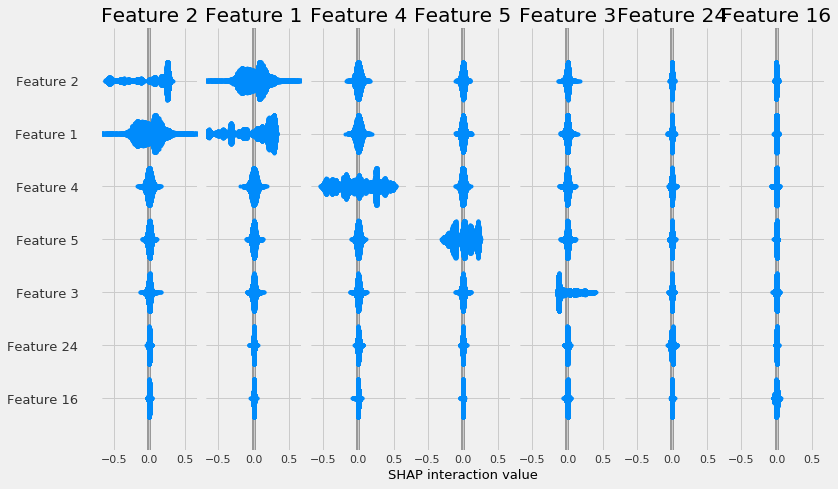

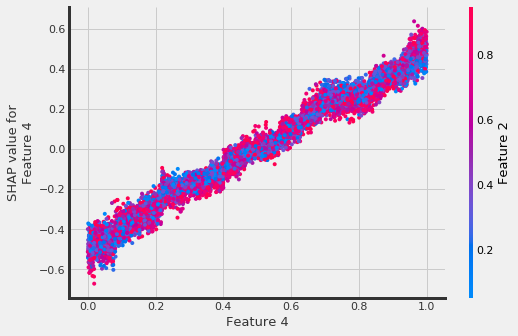

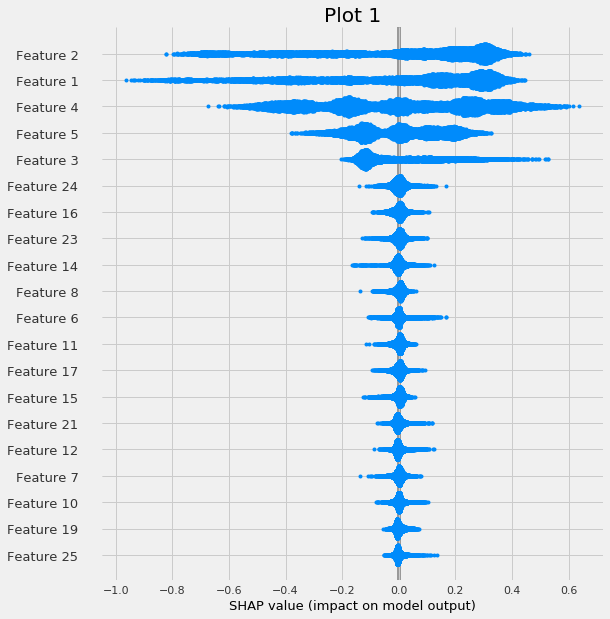

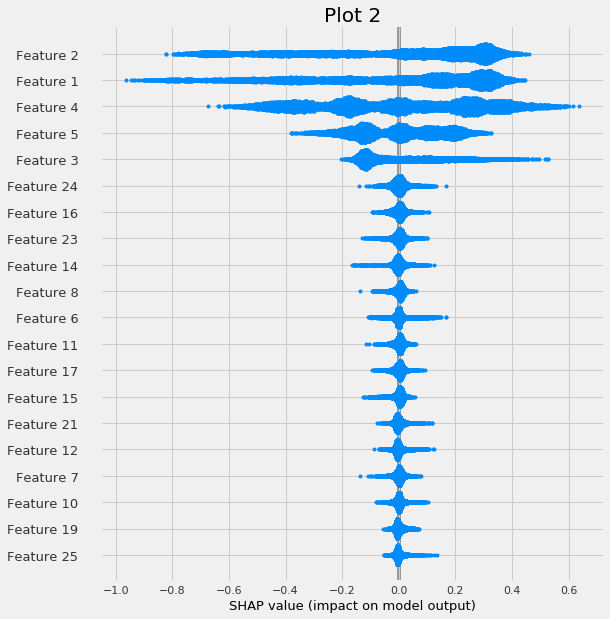

In [151]:
shap.summary_plot(shap_interaction_values)
shap.dependence_plot(4, shap_values, np.hstack((w.reshape(-1,1),X)))
plt.title('Plot 1')
shap.summary_plot(shap_values)
plt.title('Plot 2')
shap.summary_plot(shap_values)

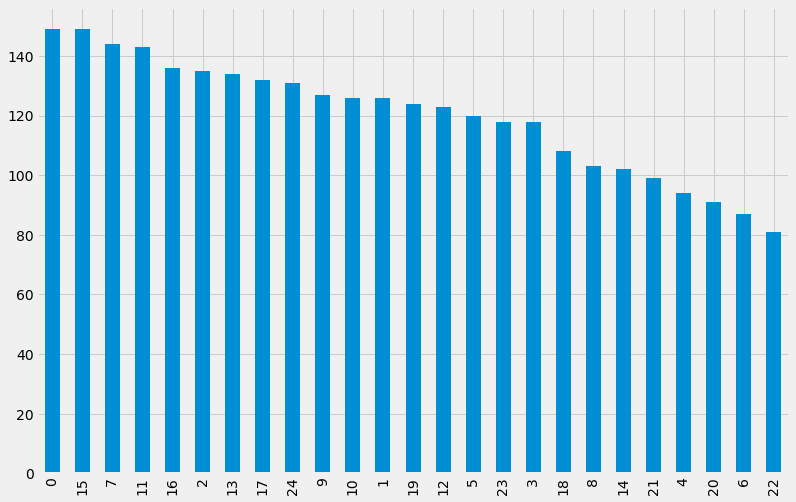

In [20]:
r_imp = pd.Series(data=rlearner.models_tau['treatment_A'].feature_importances_,
                  index=list(range(n_features)))
r_imp.sort_values(ascending=False).plot(kind='bar', figsize=(12,8))

In [157]:
explainer = lime.lime_tabular.LimeTabularExplainer(X,
                                                   feature_names=['Feature #{}'.format(i) for i in range(50)],
                                                   mode='regression')

In [181]:
i = 40
exp = explainer.explain_instance(X[i], lambda x: rlearner.predict(x).ravel(), num_features=10)

In [182]:
exp.as_list()

[('Feature #1 > 0.75', 0.2440262774642985),
 ('0.50 < Feature #0 <= 0.75', 0.07420381868396567),
 ('Feature #38 > 0.75', -0.02424363527122574),
 ('Feature #39 <= 0.25', -0.022937672726510625),
 ('0.51 < Feature #30 <= 0.75', 0.016848483747002263),
 ('0.50 < Feature #12 <= 0.75', 0.01628840944209221),
 ('Feature #8 <= 0.25', -0.014977385028813808),
 ('0.50 < Feature #6 <= 0.75', 0.014468539945050818),
 ('Feature #36 <= 0.25', 0.012226649814286042),
 ('0.50 < Feature #46 <= 0.75', 0.010924823153923017)]

In [183]:
exp.show_in_notebook(show_table=True)